# Age prediction


In [1]:
%load_ext autoreload
%autoreload 2

In [259]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot
from utilities import montecarlo_crossvalidation
from utilities import model_optimization
from utilities import variable_importance_df

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data_copy[dList]

In [7]:
tsetse_males_thorax = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Head')]

In [8]:
tsetse_males_thorax.groupby("Age")["ID"].count()

Age
5w    93
7w    92
Name: ID, dtype: int64

In [9]:
tsetse_males_head.groupby("Age")["ID"].count()

Age
5w    94
7w    93
Name: ID, dtype: int64

In [10]:
tsetse_males_thorax_copy = tsetse_males_thorax.copy()
tsetse_males_head_copy = tsetse_males_head.copy()

In [11]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_thorax = tsetse_males_thorax[dList]
tsetse_males_thorax_copy.drop(dList, axis=1,inplace=True)


descriptorsDF_head = tsetse_males_head_copy[dList]
tsetse_males_head_copy.drop(dList, axis=1,inplace=True)

In [12]:
waveNumslist = tsetse_males_thorax_copy.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [13]:
y_labels_head = descriptorsDF_head['Age']
y_labels_thorax = descriptorsDF_thorax['Age']

## Clustering

In [21]:
# males head
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_males_head_copy)
embedding_head = reducer.fit_transform(features_scaled)

In [22]:
# Females thorax
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_males_thorax_copy)
embedding_thorax= reducer.fit_transform(features_scaled)

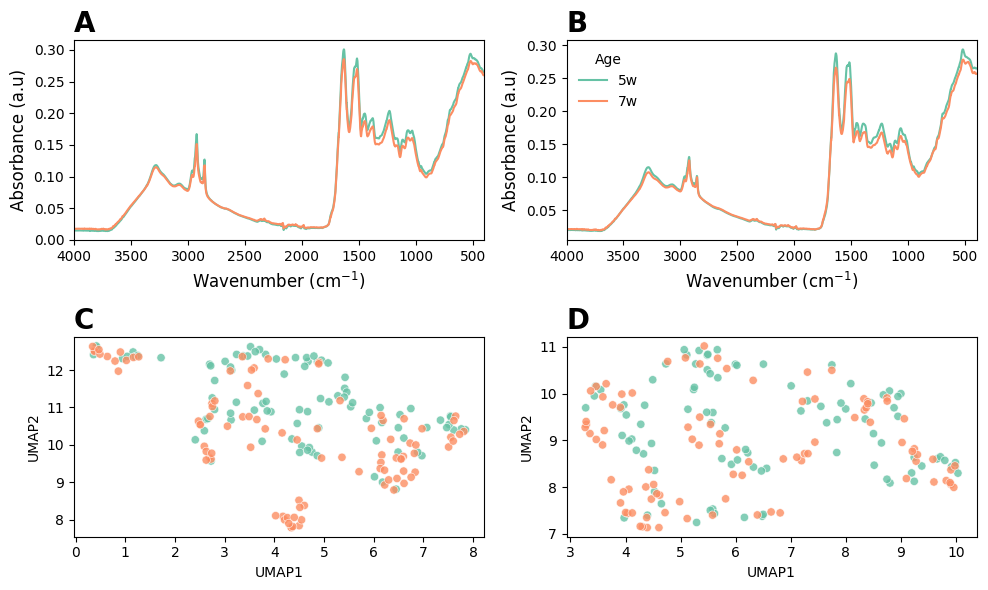

In [23]:
sn.set_palette("Set2")

fig, ((ax, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,6))

# head
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1], alpha=0.8, hue=descriptorsDF_head['Age'],ax=ax3, legend=False)
ax3.set_xlabel("UMAP1")
ax3.set_ylabel("UMAP2")

# thorax
sn.scatterplot(x=embedding_thorax[:,0], y=embedding_thorax[:,1], alpha=0.8, hue=descriptorsDF_thorax['Age'],legend=False,ax=ax4)
ax4.set_xlabel("UMAP1")
ax4.set_ylabel("UMAP2")
#ax3.legend( bbox_to_anchor=(0.5, 0.05, 0.3, 0.1),ncols=3,frameon=False)



# head
for i, c in zip(np.unique(y_labels_head), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_males_head_copy[y_labels_head == i], axis=0), label=i, color=c, ax=ax)
ax.get_legend().remove()
ax.set_xlim(4000,401)
ax.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax.set_ylabel("Absorbance (a.u)",fontsize=12)

# thorax
for i, c in zip(np.unique(y_labels_thorax), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_males_thorax_copy[y_labels_thorax == i], axis=0), label=i, color=c,ax=ax2)
ax2.set_xlim(4000,401)
ax2.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax2.set_ylabel("Absorbance (a.u)",fontsize=12)
ax2.legend(title="Age",frameon=False)


labeles = ["A", "B", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='left', fontsize=20, fontweight='bold')



plt.tight_layout()
plt.savefig("../results/plots/UMAP_Spectra_age_males.png", dpi=300)

## Age prediction males

In [339]:
X_thorax_part1 = tsetse_males_thorax.loc[:,"1800":"600"]
X_thorax_part2 = tsetse_males_thorax.loc[:,"3500":"2750"]

X_thorax_desbiased = pd.concat([X_thorax_part2,X_thorax_part1],axis=1)

y_thorax = tsetse_males_thorax.loc[:,"Age"]

X_head_part1 = tsetse_males_head.loc[:,"2500":"1800"]
y_head = tsetse_males_head.loc[:,"Age"]

In [340]:
X_thorax_desbiased

,3500,3498,3496,3494,3492,3490,3488,3486,3484,3482,...,618,616,614,612,610,608,606,604,602,600
804,0.04626,0.04626,0.04671,0.04709,0.04742,0.04775,0.04814,0.04853,0.04884,0.04920,...,0.21379,0.21406,0.21423,0.21459,0.21492,0.21517,0.21536,0.21551,0.21614,0.21739
807,0.04110,0.04110,0.04131,0.04156,0.04187,0.04225,0.04275,0.04322,0.04346,0.04357,...,0.21196,0.21217,0.21157,0.21090,0.21031,0.20967,0.20907,0.20883,0.20894,0.20951
810,0.04285,0.04285,0.04303,0.04322,0.04344,0.04379,0.04430,0.04477,0.04508,0.04532,...,0.19028,0.19056,0.19092,0.19154,0.19215,0.19249,0.19281,0.19344,0.19442,0.19547
813,0.04841,0.04841,0.04888,0.04929,0.04955,0.04980,0.05021,0.05065,0.05112,0.05158,...,0.21388,0.21472,0.21534,0.21548,0.21516,0.21502,0.21549,0.21624,0.21692,0.21777
816,0.05072,0.05072,0.05112,0.05152,0.05182,0.05211,0.05252,0.05287,0.05323,0.05373,...,0.23281,0.23391,0.23485,0.23574,0.23618,0.23646,0.23722,0.23805,0.23868,0.23949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,0.04755,0.04755,0.04794,0.04829,0.04862,0.04888,0.04918,0.04960,0.05016,0.05071,...,0.21840,0.21928,0.21984,0.22061,0.22152,0.22215,0.22268,0.22345,0.22428,0.22506
1182,0.05381,0.05381,0.05424,0.05466,0.05517,0.05559,0.05591,0.05627,0.05673,0.05734,...,0.24419,0.24533,0.24604,0.24651,0.24681,0.24759,0.24890,0.25006,0.25063,0.25092
1184,0.04350,0.04350,0.04404,0.04442,0.04469,0.04498,0.04535,0.04575,0.04618,0.04672,...,0.19647,0.19726,0.19787,0.19858,0.19927,0.19969,0.20006,0.20067,0.20139,0.20225
1186,0.05455,0.05455,0.05509,0.05564,0.05615,0.05661,0.05710,0.05763,0.05815,0.05868,...,0.24704,0.24806,0.24903,0.24990,0.25043,0.25085,0.25153,0.25234,0.25324,0.25445


In [342]:
waveNumslist_reduced = X_thorax_desbiased.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

In [343]:
# permutation test

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier



#clf2 = LogisticRegression()
#clf = SVC(kernel="rbf", random_state=7)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)
#cv = StratifiedKFold(2, shuffle=True, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=7))])

score_age, perm_scores_age, pvalue_age = permutation_test_score(
    pipe, X_thorax_desbiased, y_thorax, scoring="accuracy", cv=cv, n_permutations=100)

(0.0, 1.0)

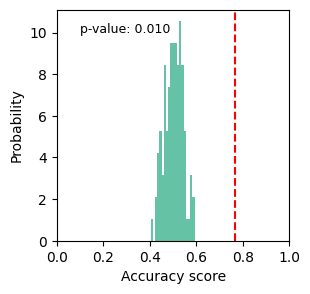

In [344]:
sn.set_palette('Set2')
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(perm_scores_age, bins=20, density=True)
ax.axvline(score_age, ls="--", color="r")
score_label = f"p-value: {pvalue_age:.3f}"
ax.text(0.1, 10, score_label, fontsize=9)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
ax.set_xlim(0,1)

#plt.savefig("../results/plots/permutationtest_age_males.png", dpi=300, bbox_inches='tight')

In [221]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [16]:
shape_data = {"train_head": X_hd_train.shape,
              "train_thorax": X_th_train.shape,
              "test_head": X_hd_test.shape,
              "tsetse_thorax":X_th_test.shape}

In [17]:
shape_data_df = pd.DataFrame(shape_data,index=['samples','features'])
shape_data_df

,train_head,train_thorax,test_head,tsetse_thorax
samples,149,148,38,37
features,1800,1800,1800,1800


In [18]:
shape_data_df.to_excel("../results/tables/train_test_shape_age_males.xlsx")

In [19]:
shape_data_classes = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "tsetse_thorax":y_th_test.value_counts()}

shape_data_classes_df = pd.DataFrame(shape_data_classes)
shape_data_classes_df
shape_data_classes_df.to_excel("../results/tables/train_test_shape_age_classes_males.xlsx")

In [222]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [223]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

<Axes: xlabel='param_clf', ylabel='value'>

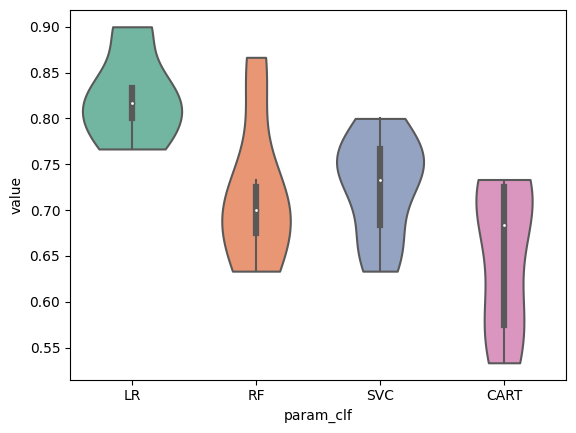

In [224]:
sn.violinplot(data=data_plot_head, x='param_clf',y='value', cut=0)

In [225]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)


Best model parameters{'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [226]:
# thorax

best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [227]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [228]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9473684210526315
Accuracy on test set: 0.8648648648648649


In [229]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
5w,1.000000,0.923077,0.960000,26.000000
7w,0.857143,1.000000,0.923077,12.000000
accuracy,0.947368,0.947368,0.947368,0.947368
macro avg,0.928571,0.961538,0.941538,38.000000
weighted avg,0.954887,0.947368,0.948340,38.000000


In [125]:
report_head.to_excel("../results/tables/accuracy_age_males_head.xlsx")

In [230]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
5w,0.904762,0.863636,0.883721,22.000000
7w,0.812500,0.866667,0.838710,15.000000
accuracy,0.864865,0.864865,0.864865,0.864865
macro avg,0.858631,0.865152,0.861215,37.000000
weighted avg,0.867358,0.864865,0.865473,37.000000


In [127]:
report_thorax.to_excel("../results/tables/accuracy_age_males_thorax.xlsx")

In [231]:
roc_head = roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1])

In [232]:
auc_roc_results = pd.DataFrame({"ROC value": [roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1]), roc_auc_score(y_th_test, pipe_thorax.predict_proba(X_th_test)[:,1])]},index=['head','thorax'])

print(auc_roc_results)

auc_roc_results.to_excel("../results/tables/roc_values_age_males.xlsx")


        ROC value
head     0.987179
thorax   0.948485


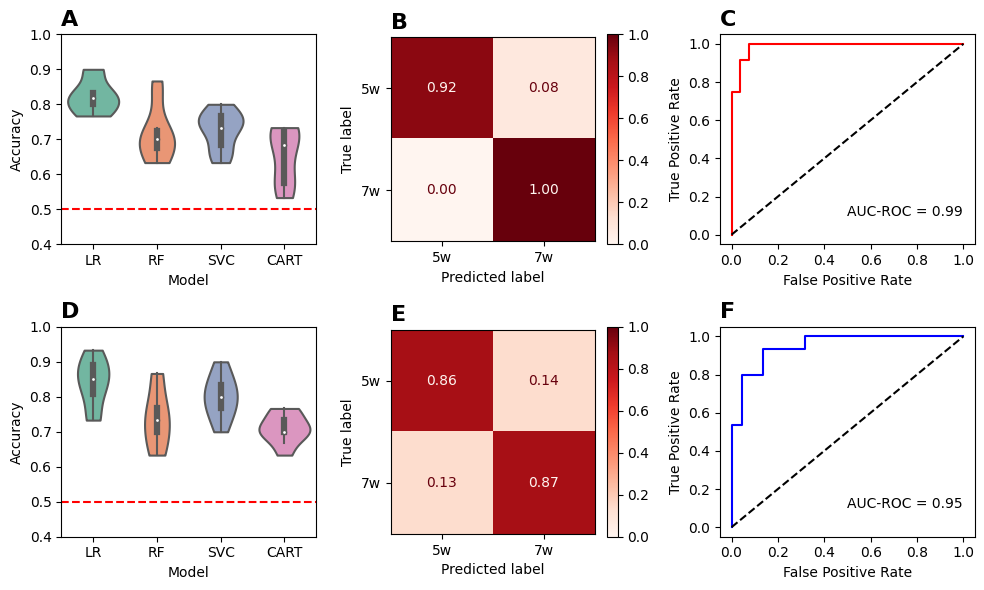

In [233]:
fig, ((ax,ax2, ax5),(ax3,ax4, ax6)) = plt.subplots(2,3,figsize=(10,6))
sn.violinplot(data=data_plot_head, x='param_clf',y='value',ax=ax, cut=0)
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value', cut=0,ax=ax3)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
ax3.set_ylabel("Accuracy")
ax.set_ylim(0.4,1)
ax3.set_ylim(0.4,1)
ax.axhline(0.5, color='r',ls="--")
ax3.axhline(0.5, color='r',ls="--")

ax3.set_xlabel("Model")


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})



disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


RocCurveDisplay.from_estimator(pipe_head, X=X_hd_test, y=y_hd_test, ax=ax5, color='r')
ax5.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
ax5.get_legend().remove()
ax5.set_ylabel("True Positive Rate")
ax5.set_xlabel("False Positive Rate")

RocCurveDisplay.from_estimator(pipe_thorax, X=X_th_test, y=y_th_test, ax=ax6, color='b')
ax6.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
ax6.get_legend().remove()
ax6.set_ylabel("True Positive Rate")
ax6.set_xlabel("False Positive Rate")

ax5.text(0.5,0.1,s=(f"AUC-ROC = {roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1]):.2f}"))

ax6.text(0.5,0.1,s=(f"AUC-ROC = {roc_auc_score(y_th_test, pipe_thorax.predict_proba(X_th_test)[:,1]):.2f}"))



sizeletters = 16
ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax3.set_title("D", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

#plt.savefig("../results/plots/age_prediction_males.png", dpi=300)

In [234]:
# monte carlo cross validation
# head
accuracy_head_mc, sensitivity_head_mc, specificity_head_mc = montecarlo_crossvalidation(X_head, y_head, best_model_head)



shuffle split: 100%|██████████| 100/100 [00:02<00:00, 38.19it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.82 ± 0.06


In [236]:
accuracy_thorax_mc, sensitivity_thorax_mc, specificity_thorax_mc = montecarlo_crossvalidation(X_thorax, y_thorax, best_mdoel_thorax)

shuffle split: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.91 ± 0.05


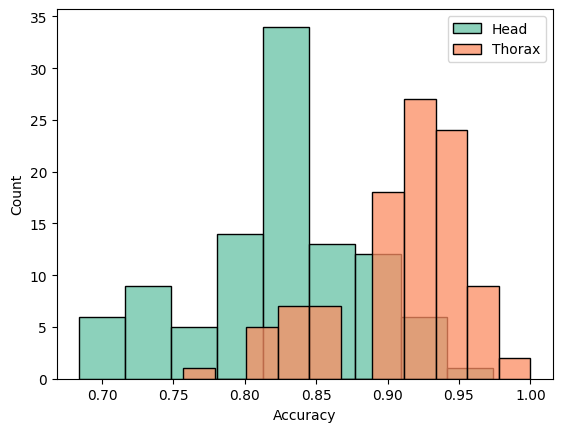

In [237]:
fig, ax = plt.subplots()
sn.histplot(accuracy_head_mc, label='Head', ax=ax)
sn.histplot(accuracy_thorax_mc, label='Thorax',ax=ax)
ax.set_xlabel("Accuracy")
plt.legend()


In [105]:
monte_carlo = pd.DataFrame({"Accuracy": [np.mean(accuracy_head_mc),
                                         np.mean(accuracy_thorax_mc)], 
                            "std":[np.std(accuracy_head_mc),
                                   np.std(accuracy_thorax_mc)], 
                            "Sensitivity":[np.mean(sensitivity_head_mc),
                                           np.mean(sensitivity_thorax_mc)],
                            "std_s": [np.std(sensitivity_head_mc),
                                           np.std(sensitivity_thorax_mc)],
                            "Specificity": [np.mean(specificity_head_mc),
                                          np.mean(specificity_thorax_mc)],
                            "std_sp": [np.std(specificity_head_mc),
                                          np.std(specificity_thorax_mc)]}, index=['head','thorax'])

In [106]:
monte_carlo.to_excel("../results/tables/age_prediction_males_mc.xlsx")

In [263]:
top20_head = variable_importance_df(wavenumbers_reduced, best_model_head)
top20_thorax = variable_importance_df(wavenumbers_reduced, best_mdoel_thorax)

In [264]:
top20_thorax

,Wavenumbers,Coefficients
484,782,3.599172
483,784,3.336597
0,1750,3.200746
143,1464,2.995010
144,1462,2.836680
29,1692,2.785488
37,1676,2.780266
36,1678,2.780266
38,1674,2.692526
35,1680,2.665774


Text(1040, -2.260752, '1040')

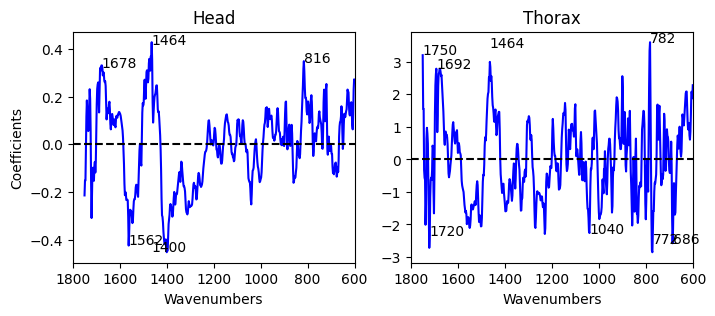

In [286]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,3),sharex=True)

sn.lineplot(x=wavenumbers_reduced,y=best_model_head['model'].coef_[0], color='b',ax=ax)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)),color='k',alpha=0.5,ax=ax)
ax.axhline(y=0, color="k", ls="--")
ax.set_xlim(1800,600)
ax.annotate('1464', xy=(1464,0.4214), xycoords='data',fontsize=10)
ax.annotate('1678', xy=(1678,0.3214), xycoords='data',fontsize=10)
ax.annotate('816', xy=(816,0.344), xycoords='data',fontsize=10)
ax.annotate('1400', xy=(1464,-0.45), xycoords='data',fontsize=10)
ax.annotate('1562', xy=(1562,-0.42), xycoords='data',fontsize=10)
ax.set_xlabel("Wavenumbers")
ax.set_ylabel("Coefficients")
ax.set_title("Head")


sn.lineplot(x=wavenumbers_reduced,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax2)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*6),color='k',alpha=0.5,ax=ax2)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlabel("Wavenumbers")
ax2.set_title("Thorax")
ax2.annotate('782', xy=(782,3.59), xycoords='data',fontsize=10)
ax2.annotate('1750', xy=(1750,3.214), xycoords='data',fontsize=10)
ax2.annotate('1464', xy=(1464,3.44), xycoords='data',fontsize=10)
ax2.annotate('1692', xy=(1692, 2.785488), xycoords='data',fontsize=10)
ax2.annotate('772', xy=(772,-2.59), xycoords='data',fontsize=10)

ax2.annotate('686', xy=(686,	-2.576248), xycoords='data',fontsize=10)
ax2.annotate('1720', xy=(1720, -2.324863), xycoords='data',fontsize=10)

ax2.annotate('1040', xy=(1040,-2.260752), xycoords='data',fontsize=10)